In [58]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*(x**2) - 4*x + 5

In [5]:
f(3)

20

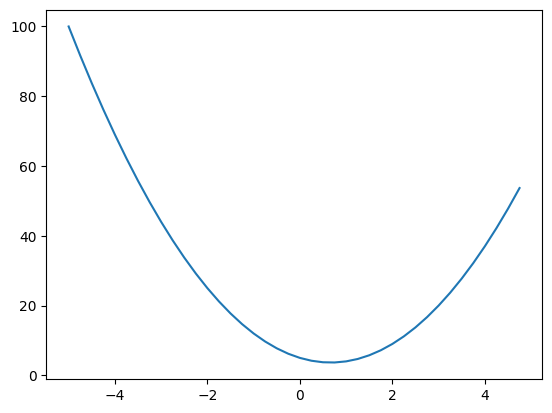

In [12]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [18]:
h = 0.00001
x = -3.0
(f(x+h) - f(x)) / h

-21.999970000052823

In [24]:
# a more complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

d1 = d
c += h
d2 = a*b + c
print(d1)
print(d2)

print('slope', (d2 - d1) / h)

4.0
4.00001
slope 0.9999999999621422


In [257]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out;
   
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out;
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert(isinstance(other, (int, float))), "only supporting int or float powers"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += (other * (self.data**(other-1))) * out.grad
        out._backward = _backward
        
        return out;
    
    def __truediv__(self, other):
        return self * (other**(-1))
    
    def __sub__(self, other):
        return self + (other * -1) 
    
    def __rsub__(self, other):
        return self - other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - (out.data)**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
#             print(self)
#             print('self.grad', self.grad)
#             print('out.grad', out.grad)
#             print ('out.data', out.data)
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    
    def backward(self):
        topo = []
        visited = set()

        def build(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build(child)
                topo.append(node)
        
        build(self)
        self.grad = 1.0
        topo.reverse()
        for node in topo:
            node._backward()   

# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# print(a + b)
# print(a * b)
# e = a * b; e.label = 'e'
# d = e + c; d.label = 'd'
# f = Value(-2.0, label='f')
# L = d * f; L.label = 'L'
# print(L)

In [193]:
# Is backward for pow working?
a = Value(3.0)
# c = 2 * a
b = (2 * a).exp()
print(b)
b.grad = 1
b.backward()
print(b._backward)
# c._backward()
# print(c.grad)
print(a.grad)

Value(data=403.4287934927351)
[Value(data=2), Value(data=3.0), Value(data=6.0), Value(data=403.4287934927351)]
self.grad 0
out.grad 1.0
out.data 403.4287934927351
<function Value.exp.<locals>._backward at 0x11502e9d0>
806.8575869854702


In [139]:
a = Value(1.0)
a * 2
2 * a

Value(data=2.0)

In [117]:
from graphviz import Digraph

def dfs(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = dfs(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        
        if (n._op):
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

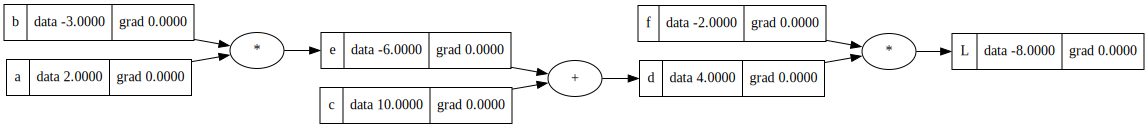

In [91]:
draw_dot(L)

[Value(data=1), Value(data=6.881373587019543), Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=2), Value(data=1.7627471740390863), Value(data=5.828427124746192), Value(data=6.828427124746192), Value(data=0.1464466094067262), Value(data=-1), Value(data=4.828427124746192), Value(data=0.7071067811865477)]
Value(data=1.7627471740390863)
self.grad 0
out.grad 0.04289321881345247
out.data 5.828427124746192


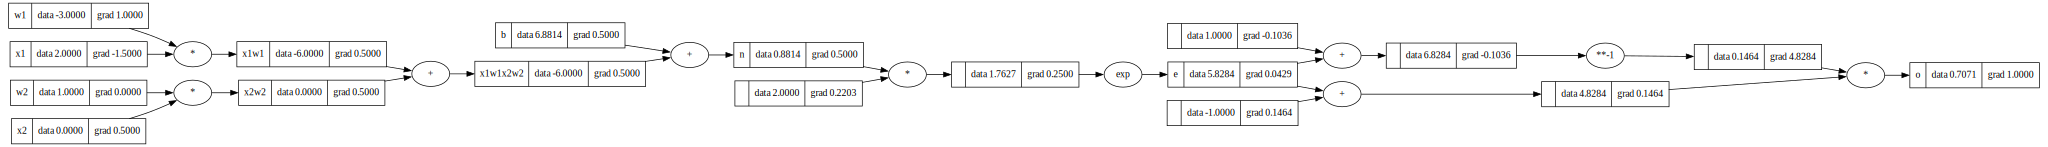

In [205]:
# Backpropagation of a neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2 * n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
# o = n.tanh();


o.backward()
draw_dot(o)

In [119]:
# topo = []
# visited = set()

# def build(node):
#     if node not in visited:
#         visited.add(node)
#         for child in node._prev:
#             build(child)
#     topo.append(node)

# build(o)
# print(topo)

[Value(data=1.0), Value(data=0.0), Value(data=0.0), Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=-6.0), Value(data=6.881373587019543), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


In [120]:
# o.grad = 1.0
# topo.reverse()
# for node in topo:
#     node._backward()

In [102]:
o.grad = 1
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [78]:
# o.grad = 1.0
# # do/dn = 1 - tanh(n)**2 = 1 - o.data**2 
# n.grad = 0.5
# b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
# w1.grad = 1.0
# x1.grad = -1.5
# x2.grad = 0.5
# w2.grad = 0.0

In [79]:
x1w1x2w2.grad = 0.5

In [80]:
n.grad = 0.5

In [84]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [127]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

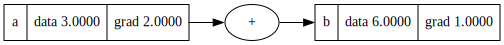

In [130]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [210]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('___')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
___
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [373]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # return w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params;
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = [p for layer in self.layers for p in layer.parameters()]
        return params
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)

l = Layer(4, 4)
x = [1.0, 2.0, 3.0, 4.0]
l(x)

n = MLP(3, [4, 4, 1])
x = [1.0, 2.0, 3.0]
n(x)
len(n.parameters())
# draw_dot(n(x))


41

In [275]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

[Value(data=0.6373724776446325),
 Value(data=0.6079793284639242),
 Value(data=0.6507754402108894),
 Value(data=0.41088686377892575)]

In [374]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.2404332503828126)

In [380]:
for k in range(100):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    loss
    # backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    # parameter update
    for p in n.parameters():
        p.data += (-0.05) * p.grad
    
    print(k, loss.data)

0 0.02293687832554781
1 0.02224682741411795
2 0.021594273805135275
3 0.020976323006358932
4 0.02039036688186554
5 0.019834049402837062
6 0.01930523716842813
7 0.0188019939429218
8 0.01832255858799495
9 0.01786532587591945
10 0.017428829756304862
11 0.01701172871967198
12 0.016612792958995686
13 0.01623089307788473
14 0.01586499013328631
15 0.015514126833091302
16 0.015177419736024619
17 0.014854052323746307
18 0.01454326883396129
19 0.014244368759191545
20 0.013956701929230212
21 0.013679664106595695
22 0.013412693033885807
23 0.013155264880082205
24 0.012906891039803412
25 0.012667115245449731
26 0.012435510957277254
27 0.012211679000818897
28 0.011995245424843076
29 0.011785859556300697
30 0.011583192231532292
31 0.011386934185453812
32 0.011196794582569482
33 0.011012499675512821
34 0.0108337915784361
35 0.0106604271439852
36 0.010492176933836257
37 0.010328824273862182
38 0.010170164385953674
39 0.010016003589365826
40 0.009866158565205192
41 0.009720455678333023
42 0.0095787303515

In [362]:
loss.backward()

In [363]:
print(n.layers[0].neurons[0].w[0].grad)
print(n.layers[0].neurons[0].w[0].data)
print(loss)

3.515151219724695
0.065889084978611
Value(data=7.985833275376901e-07)


In [364]:
for p in n.parameters():
    p.data += (-0.01) * p.grad

In [293]:
print(n.layers[0].neurons[0].w[0].grad)
print(n.layers[0].neurons[0].w[0].data)
loss

1.1995932712870574
0.6916893816456761


Value(data=5.789210082008571)

In [381]:
ypred

[Value(data=0.9665669777529277),
 Value(data=-0.9729684683694093),
 Value(data=-0.9517875181842744),
 Value(data=0.9690117074370755)]